In [1]:
import tensorflow as tf

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.DataFrame(columns=['type', 'fold', 'img_path', 'mask_path'])
for i in [1, 2, 3, 4, 5]:
    for d in ['train', 'val', 'test']:
        imgs  = []
        masks = []
        for f in os.listdir(f'data/Fold{i}/{d}'):
            imgs.append(f'data/Fold{i}/{d}/{f}')

        for f in os.listdir(f'data/Fold{i}/{d}annot'):
            masks.append(f'data/Fold{i}/{d}annot/{f}')
            
        l = len(os.listdir(f'data/Fold{i}/{d}'))
        for j in range(l):
            img_path  = imgs[j]
            mask_path = masks[j]
            df = pd.concat([df, pd.DataFrame([[d, f'Fold{i}', img_path, mask_path]], columns=['type', 'fold', 'img_path', 'mask_path'])], axis=0)
df = df.reset_index(drop=True)
df

type   fold                      img_path   
0     train  Fold1   data/Fold1/train/A00010.jpg  \
1     train  Fold1  data/Fold1/train/A000100.jpg   
2     train  Fold1  data/Fold1/train/A000110.jpg   
3     train  Fold1  data/Fold1/train/A000120.jpg   
4     train  Fold1  data/Fold1/train/A000130.jpg   
...     ...    ...                           ...   
1900   test  Fold5    data/Fold5/test/a0_146.jpg   
1901   test  Fold5    data/Fold5/test/a0_147.jpg   
1902   test  Fold5    data/Fold5/test/a0_148.jpg   
1903   test  Fold5    data/Fold5/test/a0_149.jpg   
1904   test  Fold5    data/Fold5/test/a0_150.jpg   

                              mask_path  
0      data/Fold1/trainannot/A00010.png  
1     data/Fold1/trainannot/A000100.png  
2     data/Fold1/trainannot/A000110.png  
3     data/Fold1/trainannot/A000120.png  
4     data/Fold1/trainannot/A000130.png  
...                                 ...  
1900    data/Fold5/testannot/a0_146.png  
1901    data/Fold5/testannot/a0_147.png  
1902    data/Fold5/testannot/a0_148.png  
1903    data/Fold5/testannot/a0_149.png  
1904    data/Fold5/testannot/a0_150.png  

[1905 rows x 4 columns]

In [4]:
import tensorflow.keras as keras
class Dataset(keras.utils.Sequence):
    def __init__(
            self, 
            dataframe,
            batch_size=32, 
            shuffle=True
    ):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()    

    def __getitem__(self, ids):
        #print(self.indexes)
        indexes = self.indexes[ids*self.batch_size:(ids+1)*self.batch_size]
        #indexes = self.indexes[0:8]
        b_img  = np.empty((self.batch_size, 320, 320, 3))
        b_mask = np.empty((self.batch_size, 320, 320, 1))
        i = 0
        for j in indexes:
            img, mask = self.read_img(j)
            b_img[i, :, :, :]  = img
            b_mask[i, ...] = mask
            i = i + 1
        
        return b_img/255, b_mask
        
    def __len__(self):
        return int(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)      


    def read_img(self, i):
        # read data
        image = cv2.imread(self.df['img_path'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (320, 320))

        mask  = cv2.imread(self.df['mask_path'][i], 0)
        mask  = cv2.resize(mask, (320, 320))
        mask  = np.where(mask>112, 1, 0) 
        mask  = np.expand_dims(mask, axis=2)

        return image, mask


In [5]:
fold = df[df['fold']=='Fold1'].reset_index(drop=True)

train_df = fold[fold['type']=='train'].reset_index(drop=True)
val_df   = fold[fold['type']=='val'].reset_index(drop=True)
test_df  = fold[fold['type']=='test'].reset_index(drop=True)

train_dataset = Dataset(dataframe=train_df, batch_size=4, shuffle=True)
vala_dataset  = Dataset(dataframe=val_df,batch_size=1,shuffle=True)
test_dataset  = Dataset(dataframe=test_df,batch_size=1,shuffle=True)

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 3))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

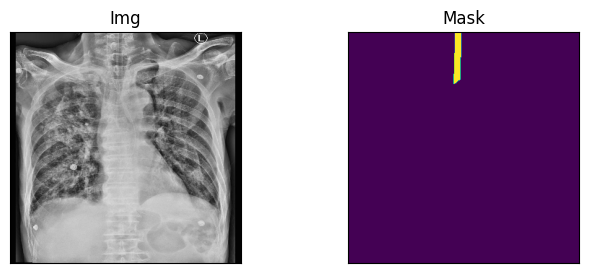

In [7]:
visualize(img=(train_dataset[0][0][0]*255).astype('int'), mask=train_dataset[0][1][0])

In [8]:
from keras_unet_collection import models, utils

* input_size：一个元组或列表，定义了输入张量的形状。
    * models.resunet_a_2d, models.transunet_2d, and models.swin_unet_2d只支持int，其他也支持input_size=(None, None, 3)。
    * activation='PReLU'与 input_size=(None, None, 3) 不兼容。
* filter_num：一个列表，定义了每个下采样和上采样块的卷积滤波器的数量。
    * 对于unet_2d, att_unet_2d, unet_plus_2d, r2_unet_2d，深度2是预期的。
    * 对于resunet_a_2d和u2net_2d，深度为3是预期的。
* n_labels：输出目标的数量，例如，对于二进制分类，n_labels=2。
* activation：隐藏层的激活函数。可用的选择有 "ReLU"、"LeakyReLU"、"PReLU"、"ELU"、"GELU"、"Snake"。
* output_activation：输出层的激活函数。建议选择 "Sigmoid"、"Softmax"、None（线性）、"Snake"。
* batch_norm：如果指定为True，所有卷积层将被配置为 "Conv2D-BN-激活 "的堆栈。
* stack_num_down：每个下采样层的卷积层数量。
* stack_num_up：每个上采样级别的卷积层（连接后）的数量。
* pool：下采样（编码）块的配置。
    * pool=False：用一个卷积层进行下采样（2×2的卷积核，2个步长；可选择批量归一化和激活）。
    * pool=True或pool='max'用最大池子层进行下采样。
    * pool='ave'下采样，带有平均池层。
* unpool：上采样（解码）块的配置。
    * unpool=False：用转置卷积层进行上采样（2-by-2卷积核，2个步长；可选择批量归一化和激活）。
    * unpool=True或unpool='bilinear' 用双线性插值进行上升采样。
    * unpool='nearest' 带反射填充的上采样。
* name：用户指定的配置的层和模型的前缀。使用keras.models.Model.summary来确定每个层的确切名称。

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, Conv2DTranspose
from coordinateAttention import coordinateAttentionLayer


number_of_filters = 2

def conv2d(filters: int):
    return Conv2D(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  kernel_regularizer=l2(0.),
                  bias_regularizer=l2(0.))


def conv2dtranspose(filters: int):
    return Conv2DTranspose(filters=filters,
                           kernel_size=(2, 2),
                           strides=(2, 2),
                           padding='same')



model_input = Input((320, 320, 3))
x00 = conv2d(filters=int(16 * number_of_filters))(model_input)
x00 = BatchNormalization()(x00)
x00 = LeakyReLU(0.01)(x00)
x00 = Dropout(0.2)(x00)
x00 = conv2d(filters=int(16 * number_of_filters))(x00)
x00 = BatchNormalization()(x00)
x00 = LeakyReLU(0.01)(x00)
x00 = Dropout(0.2)(x00)
p0 = MaxPooling2D(pool_size=(2, 2))(x00)

x10 = conv2d(filters=int(32 * number_of_filters))(p0)
x10 = BatchNormalization()(x10)
x10 = LeakyReLU(0.01)(x10)
x10 = Dropout(0.2)(x10)
x10 = conv2d(filters=int(32 * number_of_filters))(x10)
x10 = BatchNormalization()(x10)
x10 = LeakyReLU(0.01)(x10)
x10 = Dropout(0.2)(x10)
p1 = MaxPooling2D(pool_size=(2, 2))(x10)

x01 = conv2dtranspose(int(16 * number_of_filters))(x10)
x01 = concatenate([x00, x01])
x01 = conv2d(filters=int(16 * number_of_filters))(x01)
x01 = BatchNormalization()(x01)
x01 = LeakyReLU(0.01)(x01)
x01 = conv2d(filters=int(16 * number_of_filters))(x01)
x01 = BatchNormalization()(x01)
x01 = LeakyReLU(0.01)(x01)
x01 = Dropout(0.2)(x01)

x20 = conv2d(filters=int(64 * number_of_filters))(p1)
x20 = BatchNormalization()(x20)
x20 = LeakyReLU(0.01)(x20)
x20 = Dropout(0.2)(x20)
x20 = conv2d(filters=int(64 * number_of_filters))(x20)
x20 = BatchNormalization()(x20)
x20 = LeakyReLU(0.01)(x20)
x20 = Dropout(0.2)(x20)
p2 = MaxPooling2D(pool_size=(2, 2))(x20)

x11 = conv2dtranspose(int(16 * number_of_filters))(x20)
x11 = concatenate([x10, x11])
x11 = conv2d(filters=int(16 * number_of_filters))(x11)
x11 = BatchNormalization()(x11)
x11 = LeakyReLU(0.01)(x11)
x11 = conv2d(filters=int(16 * number_of_filters))(x11)
x11 = BatchNormalization()(x11)
x11 = LeakyReLU(0.01)(x11)
x11 = Dropout(0.2)(x11)

x02 = conv2dtranspose(int(16 * number_of_filters))(x11)
x02 = concatenate([x00, x01, x02])
x02 = conv2d(filters=int(16 * number_of_filters))(x02)
x02 = BatchNormalization()(x02)
x02 = LeakyReLU(0.01)(x02)
x02 = conv2d(filters=int(16 * number_of_filters))(x02)
x02 = BatchNormalization()(x02)
x02 = LeakyReLU(0.01)(x02)
x02 = Dropout(0.2)(x02)

x30 = conv2d(filters=int(128 * number_of_filters))(p2)
x30 = BatchNormalization()(x30)
x30 = LeakyReLU(0.01)(x30)
x30 = Dropout(0.2)(x30)
x30 = conv2d(filters=int(128 * number_of_filters))(x30)
x30 = BatchNormalization()(x30)
x30 = LeakyReLU(0.01)(x30)
x30 = Dropout(0.2)(x30)
p3 = MaxPooling2D(pool_size=(2, 2))(x30)

x21 = conv2dtranspose(int(16 * number_of_filters))(x30)
x21 = concatenate([x20, x21])
x21 = conv2d(filters=int(16 * number_of_filters))(x21)
x21 = BatchNormalization()(x21)
x21 = LeakyReLU(0.01)(x21)
x21 = conv2d(filters=int(16 * number_of_filters))(x21)
x21 = BatchNormalization()(x21)
x21 = LeakyReLU(0.01)(x21)
x21 = Dropout(0.2)(x21)

x12 = conv2dtranspose(int(16 * number_of_filters))(x21)
x12 = concatenate([x10, x11, x12])
x12 = conv2d(filters=int(16 * number_of_filters))(x12)
x12 = BatchNormalization()(x12)
x12 = LeakyReLU(0.01)(x12)
x12 = conv2d(filters=int(16 * number_of_filters))(x12)
x12 = BatchNormalization()(x12)
x12 = LeakyReLU(0.01)(x12)
x12 = Dropout(0.2)(x12)

x03 = conv2dtranspose(int(16 * number_of_filters))(x12)
x03 = concatenate([x00, x01, x02, x03])
x03 = conv2d(filters=int(16 * number_of_filters))(x03)
x03 = BatchNormalization()(x03)
x03 = LeakyReLU(0.01)(x03)
x03 = conv2d(filters=int(16 * number_of_filters))(x03)
x03 = BatchNormalization()(x03)
x03 = LeakyReLU(0.01)(x03)
x03 = Dropout(0.2)(x03)

x40 = conv2d(filters=int(256 * number_of_filters))(p3)
x40 = BatchNormalization()(x40)
x40 = LeakyReLU(0.01)(x40)
x40 = conv2d(filters=int(256 * number_of_filters))(x40)
x40 = BatchNormalization()(x40)
x40 = LeakyReLU(0.01)(x40)
x40 = Dropout(0.2)(x40)
x40 = coordinateAttentionLayer(x40, int(256 * number_of_filters), int(256 * number_of_filters))

x31 = conv2dtranspose(int(128 * number_of_filters))(x40)
x31 = concatenate([x31, x30])
x31 = conv2d(filters=int(128 * number_of_filters))(x31)
x31 = BatchNormalization()(x31)
x31 = LeakyReLU(0.01)(x31)
x31 = conv2d(filters=int(128 * number_of_filters))(x31)
x31 = BatchNormalization()(x31)
x31 = LeakyReLU(0.01)(x31)
x31 = Dropout(0.2)(x31)
x31 = coordinateAttentionLayer(x31, int(128 * number_of_filters), int(128 * number_of_filters))

x22 = conv2dtranspose(int(64 * number_of_filters))(x31)
x22 = concatenate([x22, x20, x21])
x22 = conv2d(filters=int(64 * number_of_filters))(x22)
x22 = BatchNormalization()(x22)
x22 = LeakyReLU(0.01)(x22)
x22 = conv2d(filters=int(64 * number_of_filters))(x22)
x22 = BatchNormalization()(x22)
x22 = LeakyReLU(0.01)(x22)
x22 = Dropout(0.2)(x22)
x22 = coordinateAttentionLayer(x22, int(64 * number_of_filters), int(64 * number_of_filters))

x13 = conv2dtranspose(int(32 * number_of_filters))(x22)
x13 = concatenate([x13, x10, x11, x12])
x13 = conv2d(filters=int(32 * number_of_filters))(x13)
x13 = BatchNormalization()(x13)
x13 = LeakyReLU(0.01)(x13)
x13 = conv2d(filters=int(32 * number_of_filters))(x13)
x13 = BatchNormalization()(x13)
x13 = LeakyReLU(0.01)(x13)
x13 = Dropout(0.2)(x13)
x13 = coordinateAttentionLayer(x13, int(32 * number_of_filters), int(32 * number_of_filters))

x04 = conv2dtranspose(int(16 * number_of_filters))(x13)
x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
x04 = conv2d(filters=int(16 * number_of_filters))(x04)
x04 = BatchNormalization()(x04)
x04 = LeakyReLU(0.01)(x04)
x04 = conv2d(filters=int(16 * number_of_filters))(x04)
x04 = BatchNormalization()(x04)
x04 = LeakyReLU(0.01)(x04)
x04 = Dropout(0.2)(x04)
x04 = coordinateAttentionLayer(x04, int(16 * number_of_filters), int(16 * number_of_filters))


output = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(x04)
model = tf.keras.Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 320, 320, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# from keras_unet_collection import losses

# def hybrid_loss(y_true, y_pred):

#     loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
#     loss_iou = losses.iou_seg(y_true, y_pred)
    
#     # (x) 
#     #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
#     return loss_focal+loss_iou #+loss_ssim


# model.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
#                   loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
#                   optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from loss import iou, weighted_loss, cce_iou_dice

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [11]:


@tf.function
def Dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return 1 - (K.mean((2. * intersection + smooth) / (union + smooth), axis=0))

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



opt = Adam(learning_rate=1e-3)
lr_metric = get_lr_metric(opt)

metrics = [Dice, iou, lr_metric]
weights_list = {1: 1.0, 2: 50.0, 3: 70.0}
loss_function = weighted_loss(cce_iou_dice, weights_list)
model.compile(optimizer=opt, loss=loss_function, metrics=metrics)

In [12]:

# 設置 ModelCheckpoint 紀錄最佳權重
model_checkpoint    = ModelCheckpoint('Unetpp_CAtt_best.h5', save_best_only=True, save_weights_only=True)
# 學習率下降
reduce_lr           = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.00005)
# 提早停止
early_stopping      = EarlyStopping(monitor='val_loss', patience=10)


# 訓練模型
history = model.fit(train_dataset, epochs=250, validation_data=vala_dataset, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/250
71/71 [==============================] - 75s 692ms/step - loss: 7.0535 - Dice: 0.9565 - iou: 0.0224 - lr: 1.0000e-03 - val_loss: 9.4162 - val_Dice: 0.9866 - val_iou: 0.0068 - val_lr: 1.0000e-03
Epoch 2/250
71/71 [==============================] - 45s 628ms/step - loss: 5.0726 - Dice: 0.8851 - iou: 0.0620 - lr: 1.0000e-03 - val_loss: 9.2676 - val_Dice: 0.9861 - val_iou: 0.0071 - val_lr: 1.0000e-03
Epoch 3/250
71/71 [==============================] - 45s 631ms/step - loss: 2.7718 - Dice: 0.6663 - iou: 0.2086 - lr: 1.0000e-03 - val_loss: 8.9478 - val_Dice: 0.9833 - val_iou: 0.0086 - val_lr: 1.0000e-03
Epoch 4/250
71/71 [==============================] - 45s 634ms/step - loss: 1.4026 - Dice: 0.4124 - iou: 0.4300 - lr: 1.0000e-03 - val_loss: 10.9876 - val_Dice: 0.9927 - val_iou: 0.0041 - val_lr: 1.0000e-03
Epoch 5/250
71/71 [==============================] - 45s 628ms/step - loss: 0.9914 - Dice: 0.3083 - iou: 0.5466 - lr: 1.0000e-03 - val_loss: 8.7428 - val_Dice: 0.8741 - val_io

In [13]:
model.evaluate(test_dataset)

47/47 [==============================] - 9s 180ms/step - loss: 0.3404 - Dice: 0.1099 - iou: 0.8075 - lr: 5.0000e-05


[0.34040701389312744,
 0.10990645736455917,
 0.8074775338172913,
 4.999999509891495e-05]

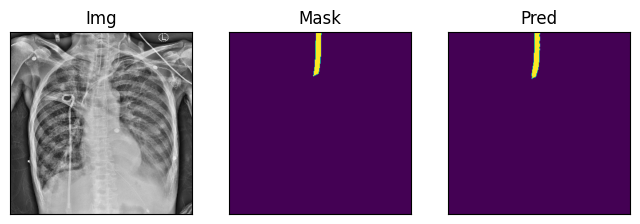

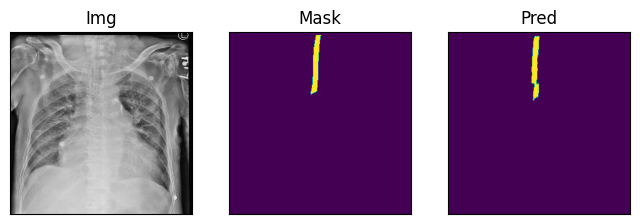

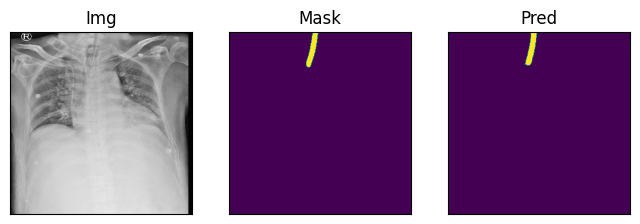

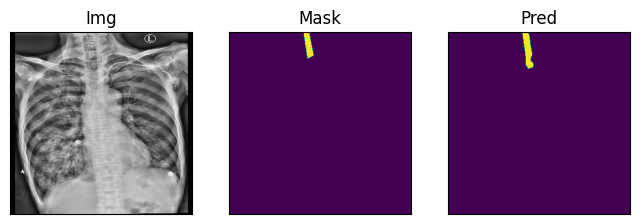

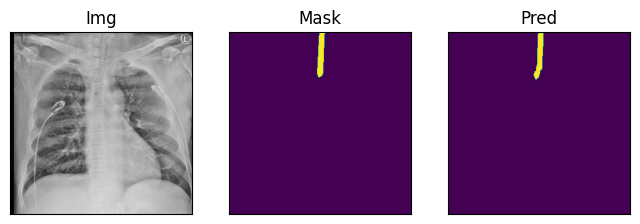

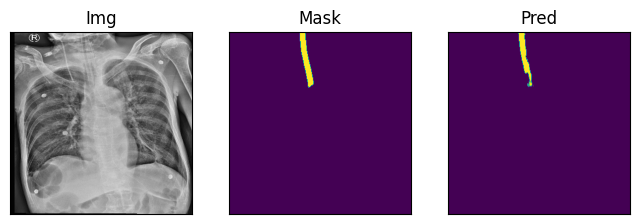

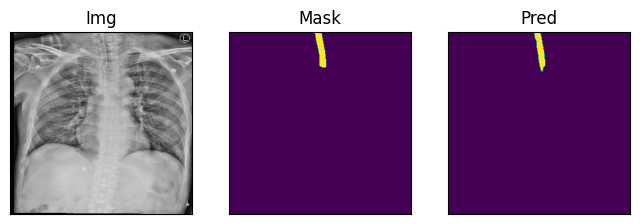

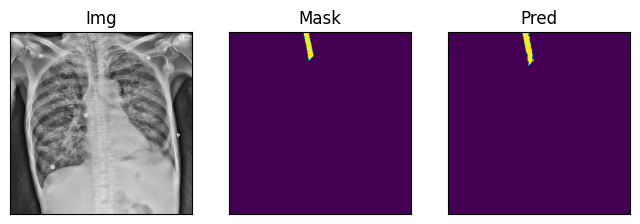

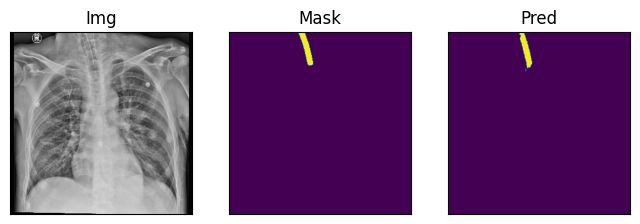

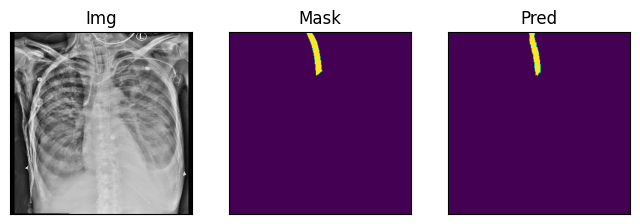

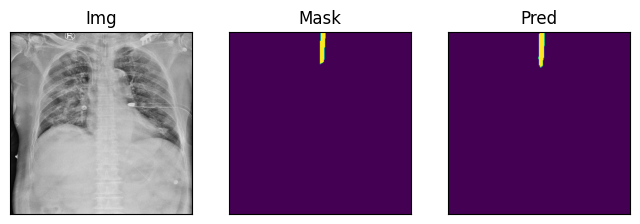

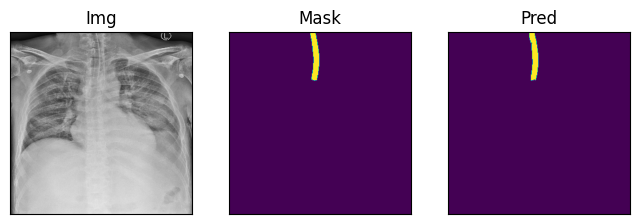

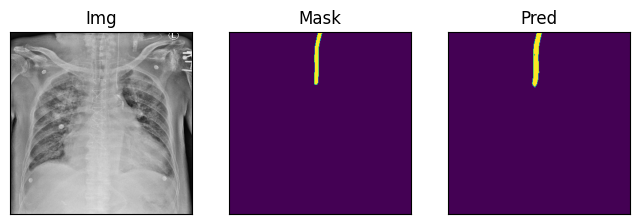

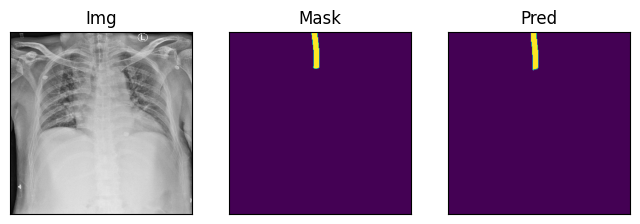

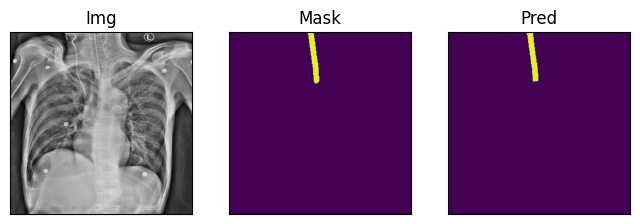

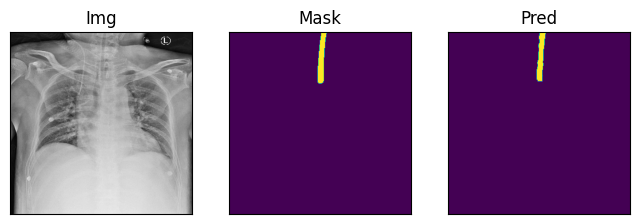

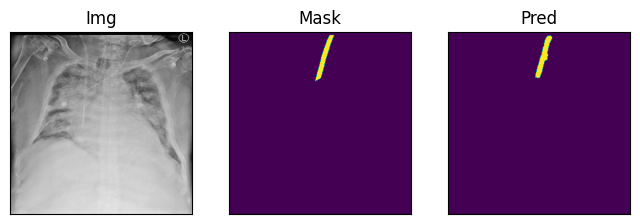

In [14]:
a = 0
for img, mask in test_dataset:
    mask_pred =model.predict(img)
    img = img * 255
    for i in range(mask_pred.shape[0]):
        visualize(img=img[i].astype('int'), mask=mask[i], pred=mask_pred[i])
    if a>15:
        break
    a =a +1